<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек-и-подготовка-окружения" data-toc-modified-id="Импорт-библиотек-и-подготовка-окружения-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек и подготовка окружения</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузим-данные" data-toc-modified-id="Загрузим-данные-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Загрузим данные</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Краткий-исследовательский-анализ" data-toc-modified-id="Краткий-исследовательский-анализ-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Краткий исследовательский анализ</a></span></li><li><span><a href="#Создание-новых-признаков-и-разделение-на-test/train" data-toc-modified-id="Создание-новых-признаков-и-разделение-на-test/train-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Создание новых признаков и разделение на test/train</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#BaseLine" data-toc-modified-id="BaseLine-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>BaseLine</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Gradient-Boosting" data-toc-modified-id="Gradient-Boosting-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Gradient Boosting</a></span></li><li><span><a href="#Резюме" data-toc-modified-id="Резюме-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Резюме</a></span></li></ul></li><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Импорт библиотек и подготовка окружения

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_columns', None)

## Подготовка

### Загрузим данные

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]).sort_index().resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [4]:
# Посмотрим, нет ли дупликатов в индексах
data.index.duplicated().sum()

0

In [5]:
# Проверим данные на монотонность
data.index.is_monotonic

True

С данными все в порядке, можно переходить дальше.

## Анализ данных

### Краткий исследовательский анализ

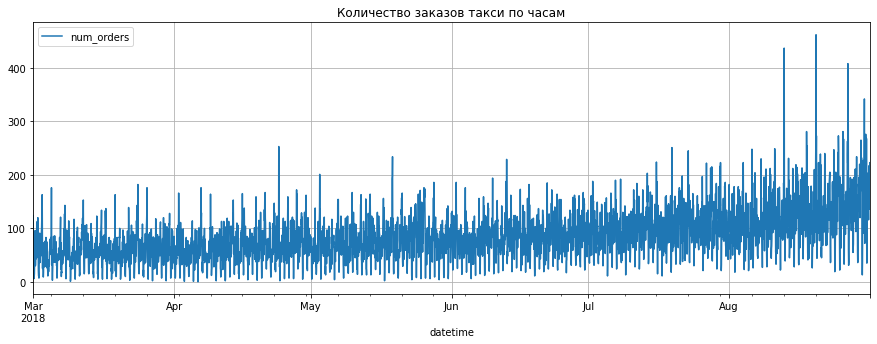

In [6]:
# Посмотрим на график заказов такси
data.plot(figsize=(15, 5), grid=True, title='Количество заказов такси по часам');

Декомпозируем временной ряд на тренд, сезонность и остатки.

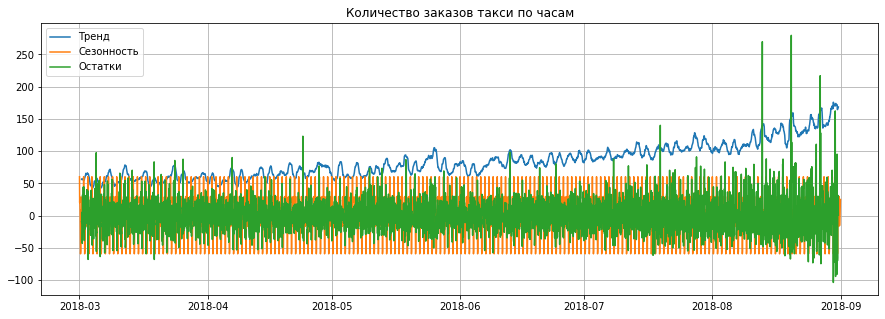

In [7]:
decompose = seasonal_decompose(data)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(decompose.trend, label='Тренд');
ax.plot(decompose.seasonal, label='Сезонность');
ax.plot(decompose.resid, label='Остатки');
plt.grid()
plt.title('Количество заказов такси по часам')
plt.legend();

Есть возрастающий тренд — количество заказов с марта по сентябрь постепенно возрастало.  
Посмотрим на сезонность на более узких временных промежутках.

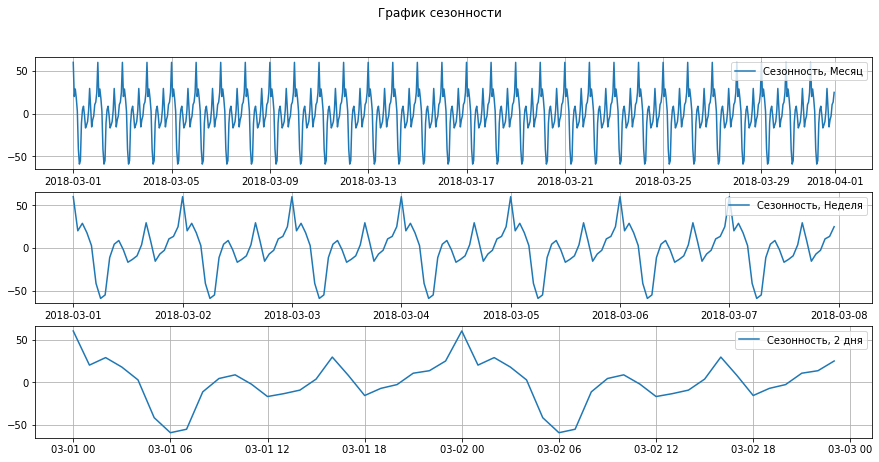

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(15, 7))
fig.suptitle('График сезонности')

ax[0].plot(decompose.seasonal['2018-03-01':'2018-03-31'], label='Сезонность, Месяц');
ax[1].plot(decompose.seasonal['2018-03-01':'2018-03-07'], label='Сезонность, Неделя');
ax[2].plot(decompose.seasonal['2018-03-01':'2018-03-02'], label='Сезонность, 2 дня');
[ax[i].grid() for i in range(len(ax))]
[ax[i].legend() for i in range(len(ax))];

"Сезонность" наблюдается в течение дня. Видно, что в поздние часы (в районе 00:00) количество заказов наибольшее, в 6 утра - наименьшее, в то время как днем количество заказов находится по середине.

### Создание новых признаков и разделение на test/train

In [9]:
# Создадим функцию для добавления новых признаков
def make_features(data, max_lag, rolling_window):
    data_new = data.copy()
    data_new['hour'] = data_new.index.hour
    data_new['day'] = data_new.index.day    
    data_new['dayofweek'] = data_new.index.dayofweek    
    data_new['week'] = data_new.index.week    
    data_new['month'] = data_new.index.month
    # Создаем признаки - значения за предыдущие периоды
    for lag in range(1, max_lag+1):
        data_new[f'lag_{lag}'] = data_new['num_orders'].shift(lag)
    # Создаем признак "скользящее среднее"
    for rol_wind in range(2, rolling_window):
        data_new[f'rolling_mean_{rol_wind}'] = data_new['num_orders'].shift(1).rolling(rol_wind).mean()
    # Удаляем пропуски
    data_new = data_new.dropna(axis=0)
    return data_new

In [10]:
# Создадим признаки для обучения
features = make_features(data, max_lag=10, rolling_window=10)

# Сохраним целевой показатель в отдельную переменную
target = features['num_orders']

# Удалим целевой показатель из переменной, в которой сохранены признаки
features = features.drop(columns='num_orders')

/tmp/ipykernel_31/2641332826.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data_new['week'] = data_new.index.week


In [11]:
# Посмотрим на созданные признаки и их размерность
print(features.shape)
features.head()

(4406, 23)


,hour,day,dayofweek,week,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean_2,rolling_mean_3,rolling_mean_4,rolling_mean_5,rolling_mean_6,rolling_mean_7,rolling_mean_8,rolling_mean_9
datetime,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 10:00:00,10,1,3,9,3,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,51.5,39.333333,32.50,27.2,29.833333,35.000000,39.500,44.555556
2018-03-01 11:00:00,11,1,3,9,3,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,66.5,55.666667,45.50,38.8,33.333333,34.714286,38.625,42.222222
2018-03-01 12:00:00,12,1,3,9,3,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,80.0,76.333333,65.75,55.6,48.333333,42.285714,42.375,45.000000
2018-03-01 13:00:00,13,1,3,9,3,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,63.0,63.333333,64.75,58.6,51.333333,45.714286,40.750,41.000000
2018-03-01 14:00:00,14,1,3,9,3,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,31.0,52.666667,55.50,58.2,54.166667,48.571429,44.000,39.777778


In [12]:
# Посмотрим на целевой показатель и его размерность
print(target.shape)
target.head()

(4406,)


datetime
2018-03-01 10:00:00    64
2018-03-01 11:00:00    96
2018-03-01 12:00:00    30
2018-03-01 13:00:00    32
2018-03-01 14:00:00    48
Freq: H, Name: num_orders, dtype: int64

In [13]:
# Разделим данные на тренировочный и тестовый наборы
train_X, test_X, train_y, test_y = train_test_split(features, target, shuffle=False, test_size=0.1)

# Выведем на экран рахмерность получившихся выборок
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((3965, 23), (3965,), (441, 23), (441,))

## Обучение

На данном этапе проверим работу трех моделей машинного обучения:
- Линейной регрессии
- Случайного леса
- Градиентного бустинга

Создадим класс кросс-валидации для временных рядов.

In [14]:
tscv = TimeSeriesSplit()

### BaseLine

In [15]:
# Предсказываем предыдущим значением
pred_previous = test_y.shift()
pred_previous.iloc[0] = train_y.iloc[-1]
print("RMSE:", mean_squared_error(test_y, pred_previous, squared=False))

RMSE: 58.91761802963282


In [16]:
# Предсказываем средним
mean = train_y.mean()
print("RMSE:", mean_squared_error(test_y, np.full(test_y.shape, mean), squared=False))

RMSE: 84.781307360467


In [17]:
print('Среднее количество такси в час', mean)

Среднее количество такси в час 78.36166456494325


Итак, в качестве бейзлайна можно взять ошибку равную 58,9 заказов такси. Такая ошибка получается, если каждое новое значение мы будем предсказывать предыдущим.

### Линейная регрессия

In [18]:
lr = LinearRegression()
lr_cv_res = cross_val_score(lr, train_X, train_y, cv=tscv, scoring='neg_root_mean_squared_error')

In [19]:
print('RMSE Линейной регрессии:', -lr_cv_res.mean())

RMSE Линейной регрессии: 12843597654.851818


### Random Forest

In [20]:
rf = RandomForestRegressor(n_estimators=500, min_samples_leaf=5, max_features=0.33, random_state=0)
rf_cv_res = cross_val_score(rf, train_X, train_y, cv=tscv, scoring='neg_root_mean_squared_error')

In [21]:
print('RMSE Случайного леса:', -rf_cv_res.mean())

RMSE Случайного леса: 26.665157609193102


### Gradient Boosting

In [22]:
cb = CatBoostRegressor(verbose=False)
cb_cv_res = cross_val_score(cb, train_X, train_y, cv=tscv, scoring='neg_root_mean_squared_error')

In [23]:
print('RMSE Градиентного бустинга:', -cb_cv_res.mean())

RMSE Градиентного бустинга: 24.81243197949905


### Резюме

Наилучший результат на кросс-валидации показала модель градиентного бустинга: RMSE = 24,8

## Подбор гиперпараметров

На данном этапе подберем гиперпараметры для модели градиентного бустинга. Будем подбирать количество деревьев в ансамбле и максимальную глубину.

In [24]:
cb = CatBoostRegressor(verbose=False, random_seed=0)
param_grid = {'max_depth': [5, 6, 7],
              'iterations': [1000, 2000]}

gs = GridSearchCV(cb, param_grid, scoring='neg_root_mean_squared_error', cv=tscv, error_score='raise')

In [25]:
gs.fit(train_X, train_y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             error_score='raise',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f137a0472e0>,
             param_grid={'iterations': [1000, 2000], 'max_depth': [5, 6, 7]},
             scoring='neg_root_mean_squared_error')

In [26]:
# Посмотрим на наилучшие гиперпараметры
gs.best_params_

{'iterations': 2000, 'max_depth': 5}

In [27]:
# Посмотрим на наилучший результат работы модели
-gs.best_score_

24.74520332875879

Наилучшие гиперпараметры, которые удалось подобрать на кросс-валидации: 
- `iterations` — 2000
- `max_depth` — 5

## Тестирование

Используем подобранные гиперпараметры при инициализации градиентного бустинга и проверим качество его работы на тестовых даннных.

In [28]:
cb = CatBoostRegressor(verbose=False, iterations=2000, max_depth=5, random_seed=0)

In [29]:
cb.fit(train_X, train_y)
test_pred = cb.predict(test_X)
print(mean_squared_error(test_y, test_pred, squared=False))

43.02660799100518


Качество работы модели на тестовых данных составило: RMSE = 43,02 заказа.

Выведем предсказания модели на график:

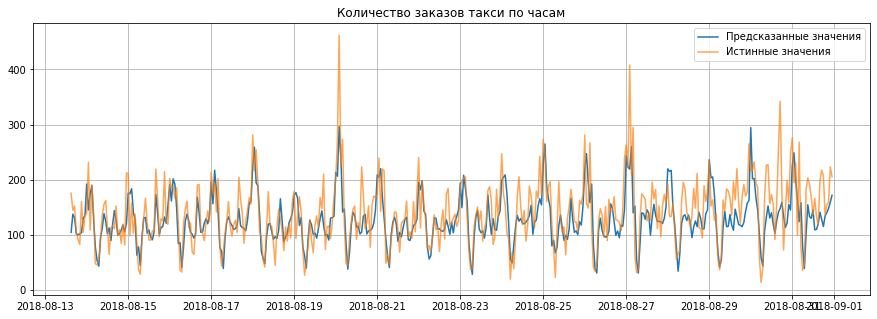

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(test_y.index, test_pred, label='Предсказанные значения')
ax.plot(test_y.index, test_y, label='Истинные значения', alpha=0.7)

plt.grid()
plt.title('Количество заказов такси по часам')
plt.legend();

Посмотрим на важность признаков:

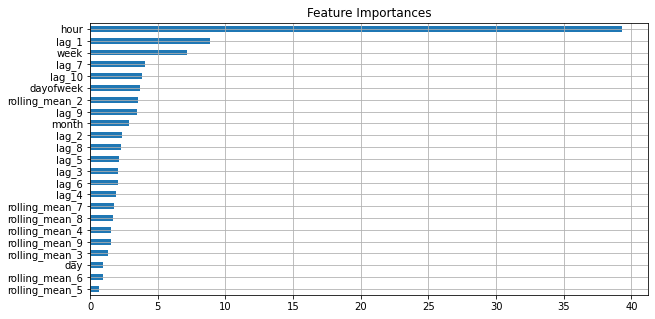

In [30]:
pd.DataFrame(cb.feature_importances_, index=train_X.columns)\
.sort_values(by=0, ascending=True)\
.plot.barh(grid=True, title='Feature Importances', figsize=(10, 5), legend=False);

Наибольшую важность при предсказании количества заказов такси получил признак "час заказа".

## Вывод

Цель работы состояла в том, чтобы построить модель, способную предсказывать количество заказов такси в следющий час.  
В ходе работы был проведен краткий исследовательский анализ, после чего были сгенерированы признаки и выборка была разделена на тренировочный и тестовый наборы. Следующим шагом была проведена проверка качества работы трех моделей машинного обучения: линейной регрессии, случайного леса и градиентного бустинга. Наилучшее качество на кросс-валидации показала модель градиентного бустинга: RMSE = 24.8  
Следующим шагом был осуществен подбор гиперпараметров для модели градиентного бустинга.  
Наилучшими гипрепараметрами оказались максимальная глубина дерева  — 5 и количество деревьев в ансамбле — 2000. Финальная модель показала на тестовых данных RMSE равное 43,02 заказам. При этом, наиболее важным признаком, от которого зависит количество заказов в следующий час оказался сам признак "час заказа".